# Hyperplane Disk Density

In this experiment, we consider the target distribution $\nu$ given by (unnormalized) density

$$
\varrho_{\nu}(x) 
= \exp\left( - \left( \textstyle \sum_{i=1}^d x_i \right)^2 - \Vert x \Vert^2 \right) ,
\qquad x = (x_1,...,x_d)^T \in \mathbb{R}^d ,
$$

in dimension $d=200$. It is easily seen that the points $x$ at which the sum term vanishes constitute a hyperplane of $\mathbb{R}^d$, i.e.~a $(d-1)$-dimensional subspace. Moreover, on rays emanating orthgonally from the hyperplane, the sum term increases like the squared Euclidean norm. It therefore leads $\nu$ to be concentrated around the hyperplane with Gaussian tails. By itself, this would not yet constitute an unnormalized density (i.e. an integrable function), so the second term is introduced to further concentrate $\nu$ on a region near the coordinate origin, with Gaussian tails on all rays emanating from the origin and running within the hyperplane. Together, the two terms produce a distribution that is concentrated on a zero-centered spherical subset of the hyperplane, which can be viewed as a (hyper-)disk.

This target serves as an example of a distribution with highly non-trivial covariance structure. Accordingly, GPSS outperforming its competitors here is meant to demonstrate that it is relatively robust against deviations of the target covariance from the identity. We compute the usual performance metrics and generate radius trace plots and step size histograms below.

In [1]:
import slice_sampling as ss
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import pandas as pd

In [2]:
# Set parameters
d = 200 # dimension, should be > 1
itnum = int(1e4) # number of chain iterations
path_prefix = "../plots/hyperplane_disk_"

### Construct the Target

In [3]:
tde_cnt = 0 # target density evaluation count

In [4]:
def log_density(x):
    global tde_cnt
    tde_cnt += 1
    return -alg.norm(x)**2 - np.sum(x)**2

### Run the Samplers

In [5]:
# initialize chains in an area of high probability mass to avoid burn-in
x_0 = np.ones(d)
x_0[-1] = 1-d
x_0 *= 10.0 / alg.norm(x_0) # WARNING: the 10.0 is hand-adjusted to dim d=200, for d=100 it should be 7.0

In [6]:
w = 20.0 # WARNING: also hand-adjusted to dim d=200

In [7]:
samples_gpss = ss.gibbsian_polar_ss(log_density, x_0, w, itnum)

In [8]:
tdes_gpss = tde_cnt
tde_cnt = 0

In [9]:
samples_hruss = ss.hit_and_run_uniform_ss(log_density, x_0, w, itnum)

In [10]:
tdes_hruss = tde_cnt
tde_cnt = 0

In [11]:
samples_ess_u = ss.naive_elliptical_ss(log_density, x_0, itnum)

In [12]:
tdes_ess_u = tde_cnt
tde_cnt = 0

In [13]:
# compute empirical covariance to feed to ESS for tuned performance
from sklearn.covariance import EmpiricalCovariance
tuned_cov = EmpiricalCovariance().fit(samples_gpss).covariance_
print(tuned_cov[0,0], np.sum(tuned_cov[0,1:]))

0.4753847239765121 -0.4738413369906618


In [14]:
# near-perfectly tuned ESS
log_likelihood = lambda x: -ss.log_prior(tuned_cov, x) + log_density(x)
samples_ess_t = ss.elliptical_ss(tuned_cov, log_likelihood, x_0, itnum)

In [15]:
tdes_ess_t = tde_cnt
tde_cnt = 0

### Collect Outputs, Compute Performance Metrics

In [16]:
snames = ["Gibbsian Polar Slice Sampling", "Hit-and-Run Uniform Slice Sampling", "Untuned Elliptical Slice Sampling", "Tuned Elliptical Slice Sampling"]
samples = [samples_gpss, samples_hruss, samples_ess_u, samples_ess_t]
tdes_per_it = np.array([tdes_gpss, tdes_hruss, tdes_ess_u, tdes_ess_t]) / itnum # target density evals per iteration
msamples = [sams[:,0] for sams in samples]
radii = mcu.get_radii_list(samples)
steps = np.array(mcu.get_steps_list(samples))
iats = mcu.iat_list(radii)

In [17]:
pd.DataFrame(
    np.array([snames, np.round(tdes_per_it, 2), np.round(iats, 2), np.round(np.mean(steps, axis=1), 2)]).T, 
    columns = ["Sampler", "TDEs/it", "IAT", "MSS"]
)

,Sampler,TDEs/it,IAT,MSS
0,Gibbsian Polar Slice Sampling,12.23,1.09,5.05
1,Hit-and-Run Uniform Slice Sampling,7.78,684.57,0.58
2,Untuned Elliptical Slice Sampling,7.91,199.17,2.42
3,Tuned Elliptical Slice Sampling,6.51,188.13,3.54


### Plotting

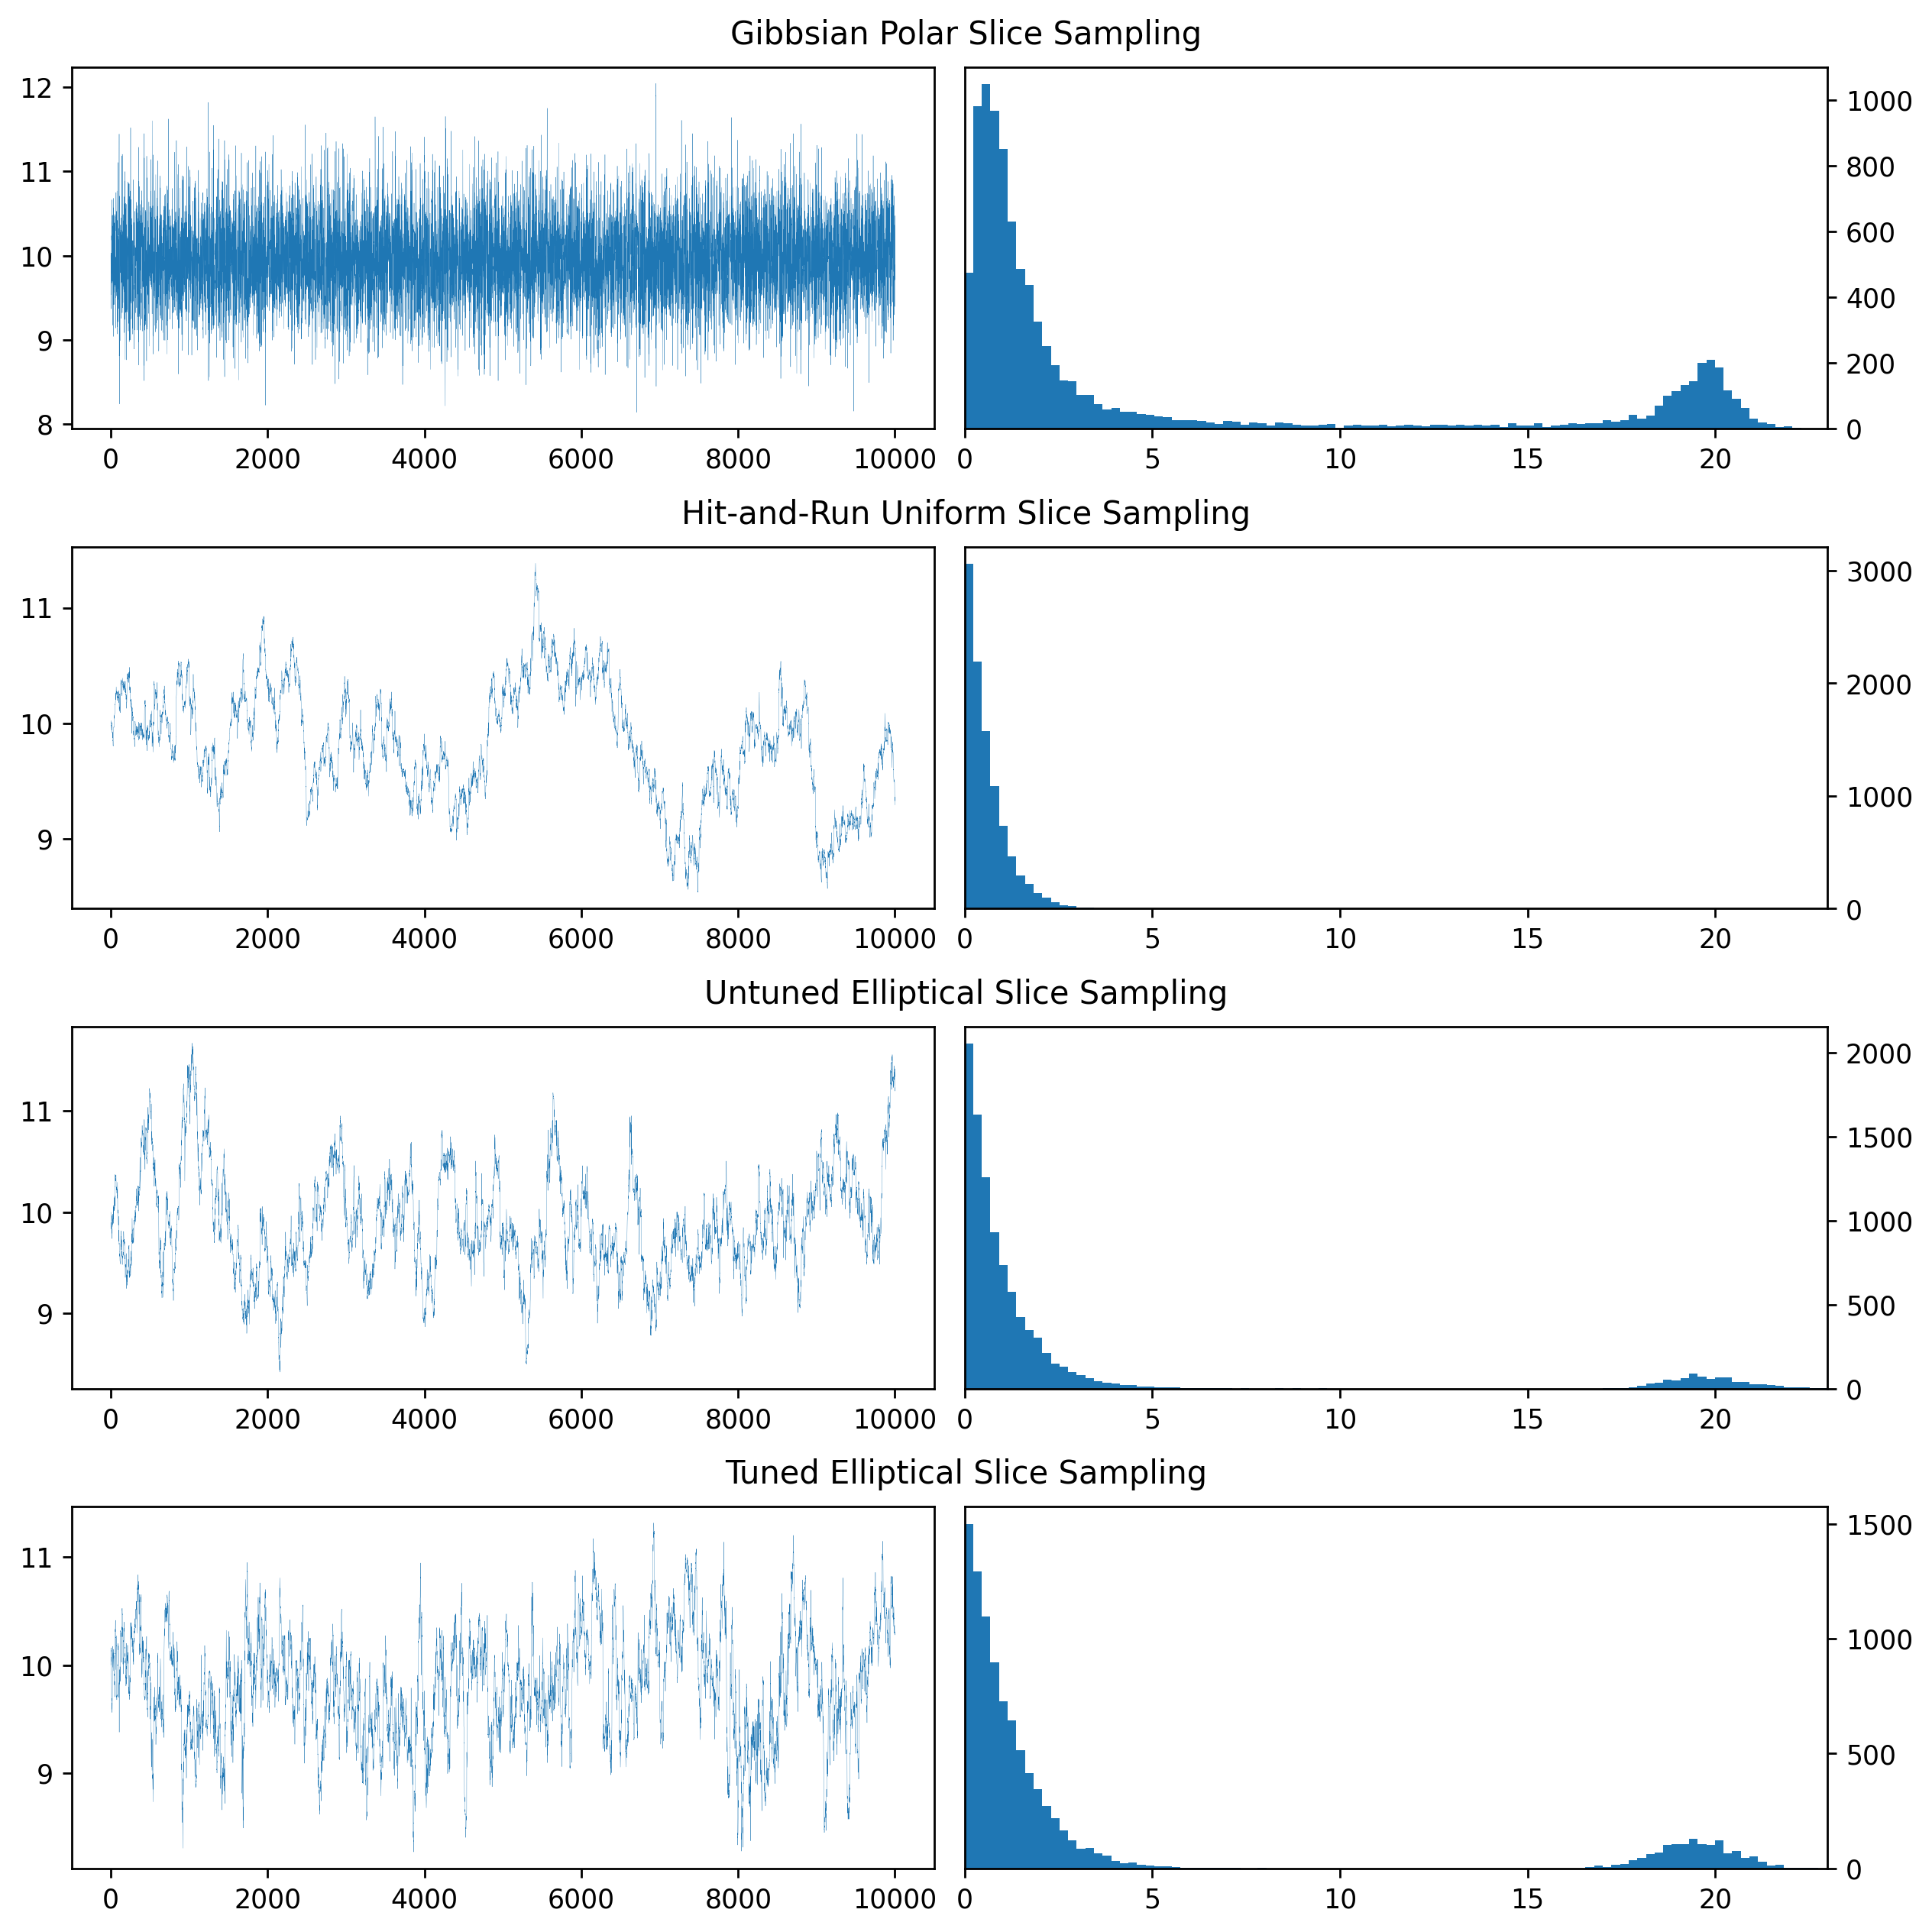

In [18]:
pfs.plot_trace_and_step_hists(radii, steps, snames, dpi=250, filepath = path_prefix + "radii_and_steps.png")